In [1]:
import matplotlib.animation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from jansen_linkage import jansenLinkage

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.ioff()
%matplotlib inline

## Utilities to build the Newton-Euler system of equations

### Variable order (along matrix row)
$F_{0,1}$, $F_{0,3}$, $F_{0,5}$, $F_{1,2}$, $F_{1,7}$, $F_{2,3}$, $F_{3,4}$, $F_{4,6}$, $F_{5,6}$, $F_{6,7}$

### Equation order (along matrix column)
- All X force balance (1- 7)
- All Y force balance (1- 7)
- All moment balance  (1- 7)

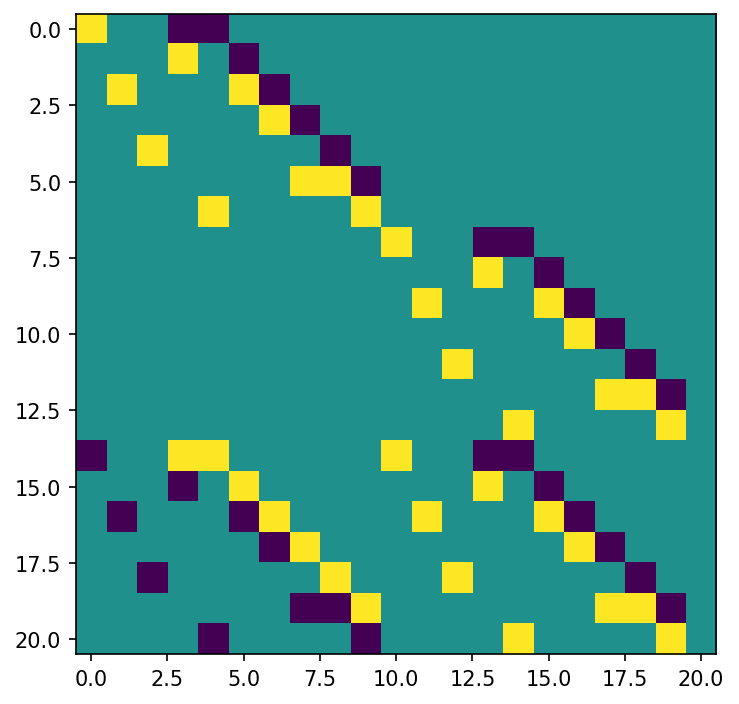

In [2]:
# link_graph = {0:[1, 3, 5],
#               1:[0, 2, 7],
#               2:[1, 3],
#               3:[0, 2, 4],
#               4:[3, 6],
#               5:[0, 6],
#               6:[4, 5, 7],
#               7:[1, 6]}

force_idx = [(0, 1),
             (0, 3),
             (0, 5),
             (1, 2), 
             (1, 7), 
             (2, 3),
             (3, 4),
             (4, 6), 
             (5, 6),
             (6, 7)]

# correspond to intersections in force_idx
joints = ["p3",
          "p0",
          "p0",
          "p1",
          "p1",
          "p2", 
          "p4",
          "p6",
          "p5",
          "p5"]


zs = np.zeros((7, 10))

for i in range(7):
    for j in range(10):
        if(i+1 == force_idx[j][0]):
            zs[i][j] = -1.0
        if(i+1 == force_idx[j][1]):
            zs[i][j] = 1.0


B = np.zeros((21,21))

B[0:7, 0:10] = zs
B[7:14, 10:20] = zs
B[14:21, 0:10] = -zs
B[14:21, 10:20] = zs

plt.imshow(B)

## Defining Masses and Moments of inertias

In [3]:
## Functions to compute mass and moi
def triangle_ar(a, b, c):
    s = (a+b+c)/2
    ar = np.sqrt((s)*(s-a)*(s-b)*(s-c))
    return ar

def line_ar(l, w):
    return l*w

def triangle_moi(a, b, c, rho):

    ar = triangle_ar(a,b,c)
    h = ar*2/b
    x = np.sqrt(a**2 - h**2)

    Ix = b*(h**3)/36
    Iy = ((b**3)*h - (b**2)*h*x + b*h*(x**2))/36
    Iz = Ix+Iy

    return rho*Iz

def line_moi(l, w, rho):

    Ix = (w**3)*l/12
    Iy = (l**3)*w/12
    Iz = Ix+Iy
    
    return rho*Iz

In [4]:
links = {'b': 12.499999999999973, 
         'c': 8.799999999999997, 
         'd': 10.2, 
         'e': 8.999999999999915, 
         'f': 10.200000000000006, 
         'g': 9.199999999999989, 
         'h': 17.500000000000007, 
         'i': 11.2, 
         'j': 18.6999999999999, 
         'k': 15.200000000000028, 
         'n': 9.999999999999986, 
         'm': 2.5999999999999828}
tn = 0.0

# link: mass
rho = 1e-3 # mass/unit area
width = 5.0 # width of binary links

mass =  { 1: rho*line_ar(links["m"], width),
          2: rho*line_ar(links["j"], width),
          3: rho*triangle_ar(links["b"], links["d"], links["e"]),
          4: rho*line_ar(links["f"], width),
          5: rho*line_ar(links["c"], width),
          6: rho*triangle_ar(links["g"], links["h"], links["i"]),
          7: rho*line_ar(links["k"], width)}

# link : moi
moi =   { 1: line_moi(links["m"], width, rho),
          2: line_moi(links["j"], width, rho),
          3: triangle_moi(links["b"], links["d"], links["e"], rho),
          4: line_moi(links["f"], width, rho),
          5: line_moi(links["c"], width, rho),
          6: triangle_moi(links["g"], links["h"], links["i"], rho),
          7: line_moi(links["k"], width, rho)}

In [5]:
### Force profiles at p7 coupler point
def fp7(angle, start, end):
    if(250*np.pi/180>angle>120*np.pi/180):
        return [0.0, 0.0]       
    else:
        return [5, 10]

In [6]:
jl = jansenLinkage(links=links, tn=tn)
com = [None for i in range(8)]
grav = 9.8 # m/s2

force_results = {"f01":[],
                 "f03":[],
                 "f05":[],
                 "f12":[],
                 "f17":[],
                 "f23":[],
                 "f34":[],
                 "f46":[],
                 "f56":[],
                 "f67":[],
                 "t01":[]}

tm_arr = np.linspace(0, 360, 360)*np.pi/180
for tm in tm_arr:
    
    wm = 1
    wn = 0
    am = 0
    an = 0

    # kinematic analysis
    pos, vel, acc, points = jl.kinematic_analysis(tm, wm, wn, am, an)
    
    # compute COM (pos, acc, vel)
    com[1] = (points["p1"] + points["p3"])/2
    com[2] = (points["p1"] + points["p2"])/2
    com[3] = (points["p0"] + points["p2"] + points["p4"])/3
    com[4] = (points["p4"] + points["p6"])/2
    com[5] = (points["p0"] + points["p5"])/2
    com[6] = (points["p5"] + points["p6"] + points["p7"])/3
    com[7] = (points["p1"] + points["p5"])/2

    # compute contact forces at p7 (coupler point)
    fp7x, fp7y = fp7(angle=tm, start=(250-360)*np.pi, end=120*np.pi)

    # compute RHS
    mass_vec = [mass[1]*com[1].acc[0],
                mass[2]*com[2].acc[0],
                mass[3]*com[3].acc[0],
                mass[4]*com[4].acc[0],
                mass[5]*com[5].acc[0],
                mass[6]*com[6].acc[0] - fp7x,
                mass[7]*com[7].acc[0],
                mass[1]*(com[1].acc[1] + grav),
                mass[2]*(com[2].acc[1] + grav),
                mass[3]*(com[3].acc[1] + grav),
                mass[4]*(com[4].acc[1] + grav),
                mass[5]*(com[5].acc[1] + grav),
                mass[6]*(com[6].acc[1] + grav) - fp7y,
                mass[7]*(com[7].acc[1] + grav),
                moi[1]*acc["am"],
                moi[2]*acc["aj"],
                moi[3]*acc["ab"],
                moi[4]*acc["af"],
                moi[5]*acc["ac"],
                moi[6]*acc["ai"] - (points["p7"].pos[0]*fp7y - points["p7"].pos[1]*fp7x),
                moi[7]*acc["ak"]]

    # compute LHS
    A = B.copy()

    for i in range(7):
        for j in range(10):
            A[i+14][j]    *= (points[joints[j]].pos[1] - com[i+1].pos[1])
            A[i+14][j+10] *= (points[joints[j]].pos[0] - com[i+1].pos[0])
            
    # Input torque term
    A[14][20] = 1.0

    # Solution
    forces = np.linalg.solve(A, mass_vec)
    for i, fi in enumerate(force_idx):
        force_results[f"f{fi[0]}{fi[1]}"].append([forces[i], forces[i+10]])
    force_results["t01"].append(forces[20])

for di in force_results:
    force_results[di] = np.array(force_results[di])

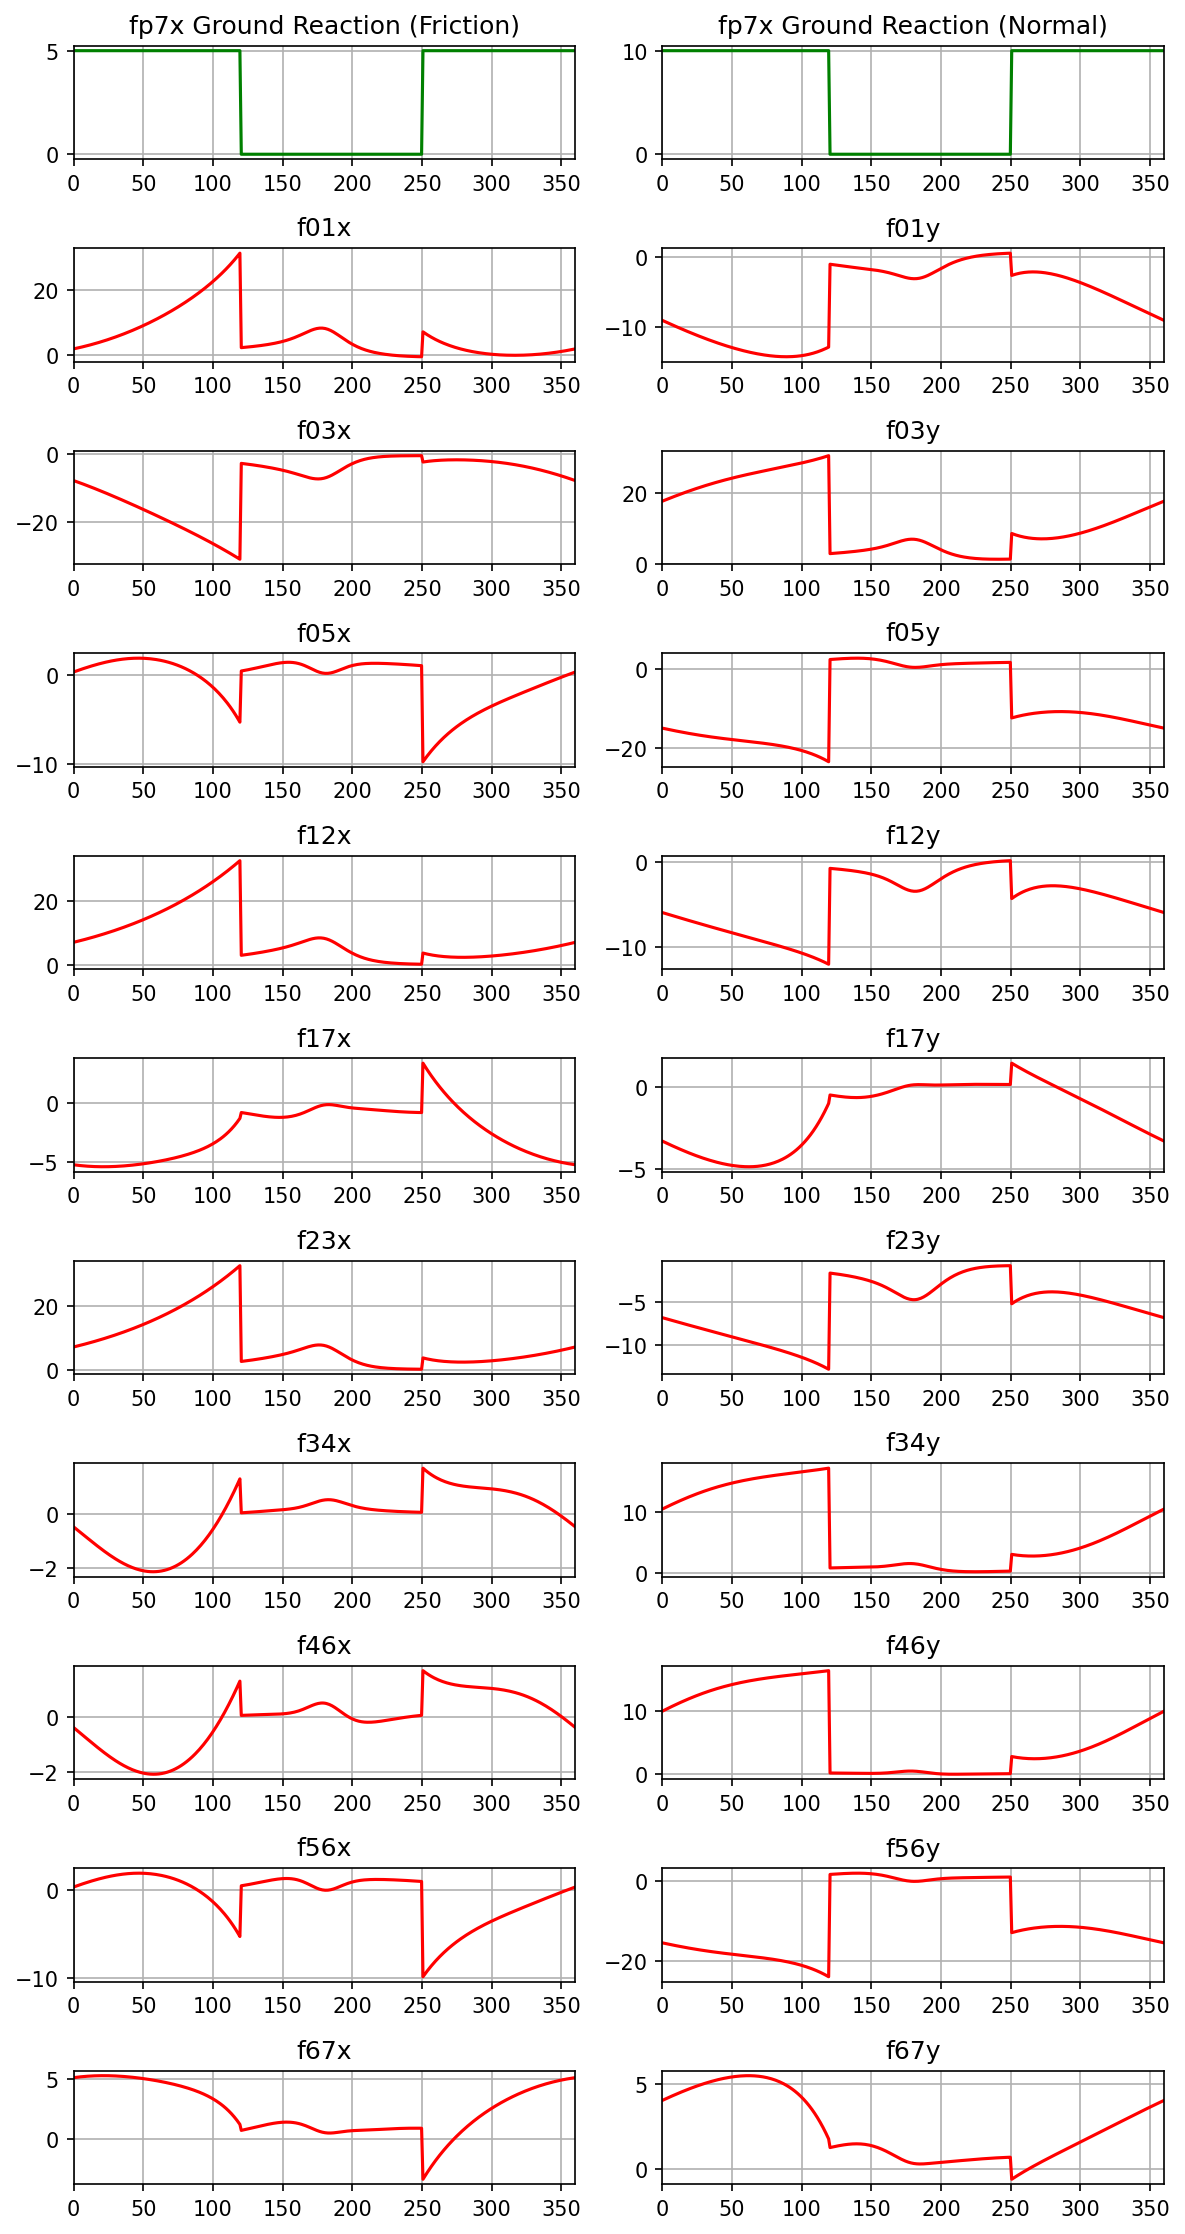

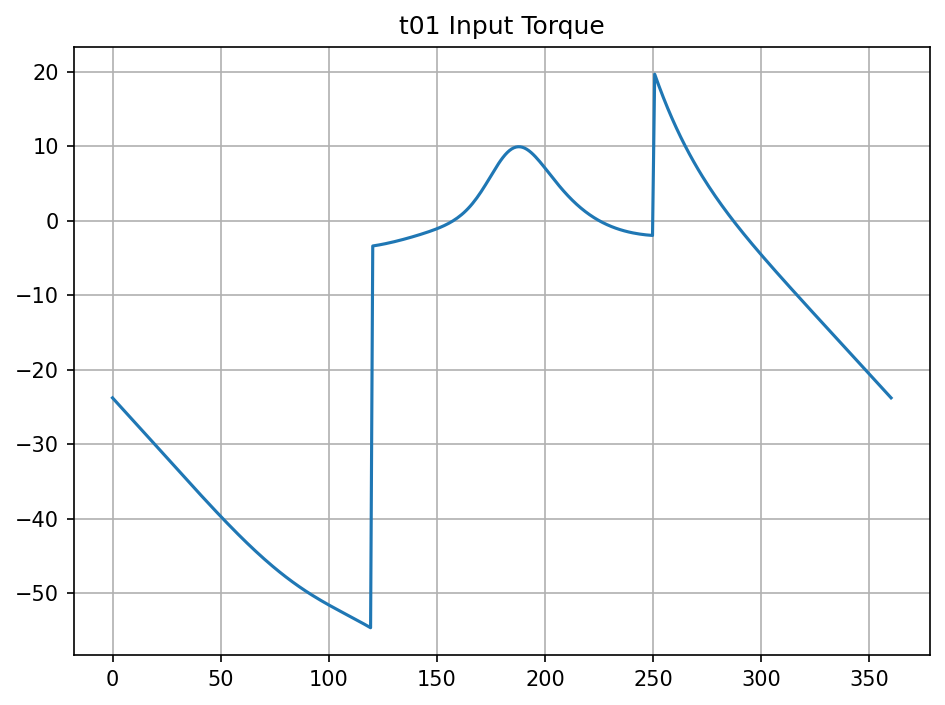

In [7]:
# Force plots
f, axs = plt.subplots(11, 2, figsize=(8, 15))

fp7x = [fp7(angle=tm, start=(250-360)*np.pi, end=120*np.pi)[0] for tm in tm_arr]
fp7y = [fp7(angle=tm, start=(250-360)*np.pi, end=120*np.pi)[1] for tm in tm_arr]

plt.subplot(11,2,1)
plt.title(f"fp7x Ground Reaction (Friction)")
plt.grid("on")
plt.xlim([0, 360])
plt.plot(tm_arr*180/np.pi, fp7x, "g")

plt.subplot(11,2,2)
plt.title(f"fp7x Ground Reaction (Normal)")
plt.grid("on")
plt.xlim([0, 360])
plt.plot(tm_arr*180/np.pi, fp7y, "g")

    

for i, di in enumerate(force_results):
    if(di == "t01"):
        continue
    plt.subplot(11,2,2*i+1+2)
    plt.title(f"{di}x")
    plt.grid("on")
    plt.xlim([0, 360])
    plt.plot(tm_arr*180/np.pi, force_results[di][:, 0], "r")
    
    plt.subplot(11,2,2*i+2+2)
    plt.title(f"{di}y")
    plt.grid("on")
    plt.xlim([0, 360])
    plt.plot(tm_arr*180/np.pi, force_results[di][:, 1], "r")

plt.savefig("../outputs/dynamic_analysis/force_plots.png")

plt.figure()
plt.title("t01 Input Torque")
plt.grid("on")
plt.plot(tm_arr*180/np.pi,force_results["t01"])
plt.savefig("../outputs/dynamic_analysis/input_torque.png")

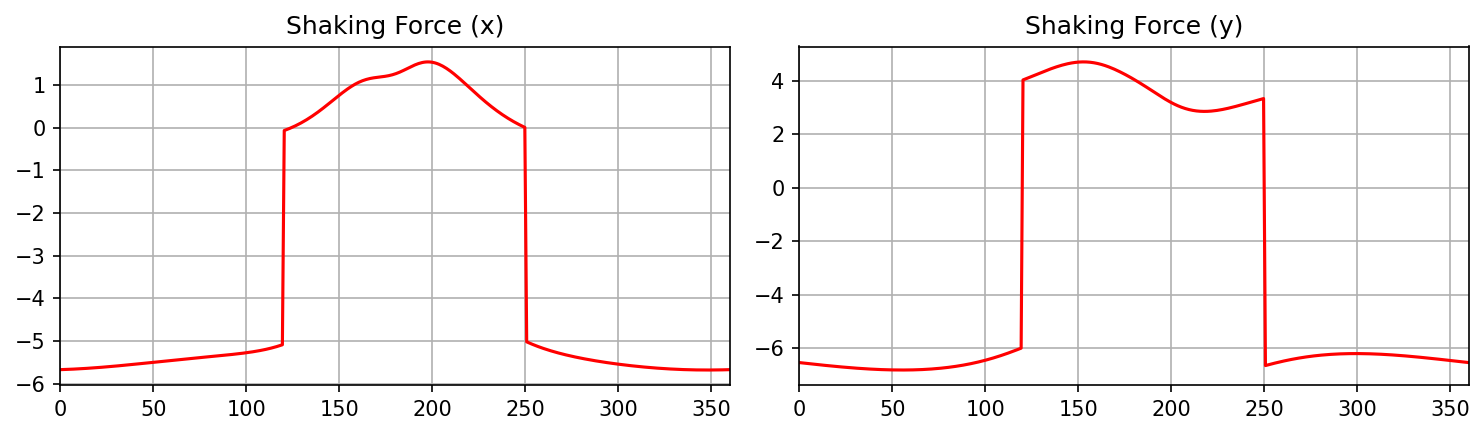

In [8]:
f, axs = plt.subplots(1, 2, figsize=(10, 3))

shake_force = (  force_results["f01"]
               + force_results["f03"]
               + force_results["f05"])

plt.subplot(1,2,1)
plt.title(f"Shaking Force (x)")
plt.grid("on")
plt.xlim([0, 360])
plt.plot(tm_arr*180/np.pi, shake_force[:, 0], "r")

plt.subplot(1,2,2)
plt.title(f"Shaking Force (y)")
plt.grid("on")
plt.xlim([0, 360])
plt.plot(tm_arr*180/np.pi, shake_force[:, 1], "r")
plt.savefig("../outputs/dynamic_analysis/shaking_force.png")